In [59]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import re

In [60]:
df = pd.read_csv("data/athlete_events.csv")
df = df[df["Sport"] == "Athletics"]
df = df.dropna(subset=['Age', 'Height', 'Weight', 'Sex', 'Event'])
df = df[["Age", "Height", "Weight", "Sex", "Event"]]

83
["Athletics Men's 1,500 metres" "Athletics Men's 1,500 metres Walk"
 "Athletics Men's 1,600 metres Medley Relay"
 "Athletics Men's 10 kilometres Walk" "Athletics Men's 10 mile Walk"
 "Athletics Men's 10,000 metres" "Athletics Men's 100 metres"
 "Athletics Men's 110 metres Hurdles"
 "Athletics Men's 2,500 metres Steeplechase"
 "Athletics Men's 2,590 metres Steeplechase"
 "Athletics Men's 20 kilometres Walk" "Athletics Men's 200 metres"
 "Athletics Men's 200 metres Hurdles" "Athletics Men's 3 mile, Team"
 "Athletics Men's 3,000 metres Steeplechase"
 "Athletics Men's 3,000 metres Walk" "Athletics Men's 3,000 metres, Team"
 "Athletics Men's 3,200 metres Steeplechase"
 "Athletics Men's 3,500 metres Walk" "Athletics Men's 4 mile, Team"
 "Athletics Men's 4 x 100 metres Relay"
 "Athletics Men's 4 x 400 metres Relay"
 "Athletics Men's 4,000 metres Steeplechase" "Athletics Men's 400 metres"
 "Athletics Men's 400 metres Hurdles" "Athletics Men's 5 mile"
 "Athletics Men's 5,000 metres" "Athleti

In [61]:
# field events, shot put jav, anything throwing
# spirts under 400
# middle distance 800 - mile
# long 5k +
# jumping pole value, high jump, long jump


def sort_athletics(e):
    e = e.lower()

    if (any(event in e for event in ["jump", "vault"])):
        return "Jump"
    elif (any(event in e for event in ["discus", "javelin", "shot put", "throw"])):
        return "Field"
    elif (any(event in e for event in ["kilometre", "cross-country", "marathon"])):
        return "Long"
    
    elif ("mile" in e):
        match = re.search(r'(\d[\d,]*)\s+mile', e)
        if match:
            length = int(match.group(1).replace(',', ''))
        else:
            print(f"ERROR: {e}") 

        if (length <= 1):
            return "Medium"
        else:
            return "Long"

    elif ("metre" in e):

        match = re.search(r'(\d[\d,]*)\s+metre', e)
        if match:
            length = int(match.group(1).replace(',', ''))
        else:
            print(f"ERROR: {e}") 

        if length <= 400:
            return "Short"
        elif (length > 400 and  length <= 1609.34):
            return "Medium"
        else:
            return "Long"
    else:
        # disgarding Decathalon, Pentathelon, Heptathlon, All Around
        return "Not Classed"
    

df["event_catagory"] = df["Event"].apply(sort_athletics)

In [65]:
df.groupby("event_catagory").size()

event_catagory
Field      3995
Jump       4142
Long       7283
Medium     2889
Short     12985
dtype: int64

In [62]:
df = df[df["event_catagory"] != "Not Classed"]
df = df.drop('Event', axis=1)

df["Sex_F"] = np.where(df['Sex'] == "F", 1, 0)
df["Sex_M"] = np.where(df['Sex'] == "M", 1, 0)
df = df.drop('Sex', axis=1)

def scale(x):
    return (x - min(x)) / (max(x) - min(x))

df[["Age", "Height", "Weight"]] = df[["Age", "Height", "Weight"]].apply(scale)

# split into features and test train split
y = df["event_catagory"]
X = df[["Age", "Height", "Weight", "Sex_F", "Sex_M"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [63]:
# train model
mlp = MLPClassifier(hidden_layer_sizes=(200, 100, 50), activation="relu", solver="adam", max_iter=1000, random_state=42)
mlp.fit(X_train, y_train)

# see how model performs
y_pred = mlp.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(accuracy)

0.6448314427224796


In [64]:
results = {"labels":y_test, "predicted":y_pred}
df_results = pd.DataFrame(results)

df_results["is_correct"] = df_results["labels"] == df_results['predicted']
df_counts = df_results.groupby(["labels", "is_correct"]).size().reset_index(name="count")

total_counts = df_results.groupby('labels').size()
correct_counts = df_results[df_results['labels'] == df_results['predicted']].groupby("labels").size()

# Compute the percentage of correct predictions
accuracy = (correct_counts / total_counts * 100).fillna(0).reset_index()
accuracy.columns = ['correct_label', 'accuracy_percentage']

accuracy

,correct_label,accuracy_percentage
0,Field,81.101377
1,Jump,16.203144
2,Long,72.807614
3,Medium,0.702988
4,Short,84.033938


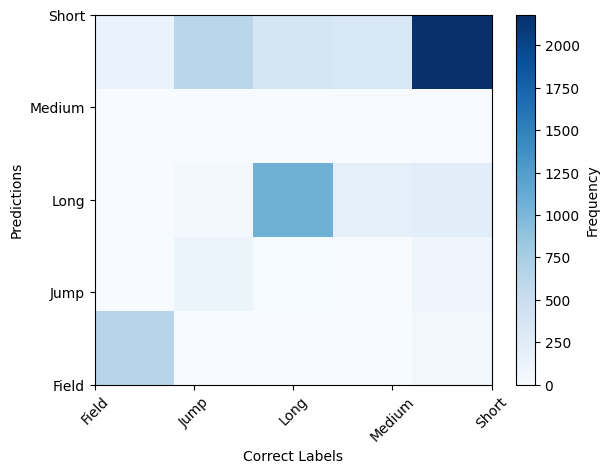

In [66]:
import matplotlib.pyplot as plt

sorted_labels = np.sort(df_results["labels"].unique())

index_dict = {label: i for i, label in enumerate(sorted_labels)}

df_results["labels_indexed"] = df_results["labels"].map(index_dict)
df_results["predictions_indexed"] = df_results["predicted"].map(index_dict)

plt.hist2d(df_results["labels_indexed"], df_results["predictions_indexed"], bins=5, cmap=plt.cm.Blues)


plt.xticks(ticks=np.arange(len(sorted_labels)), labels=sorted_labels, rotation=45)
plt.yticks(ticks=np.arange(len(sorted_labels)), labels=sorted_labels)

# Add labels and title
plt.xlabel('Correct Labels')
plt.ylabel('Predictions')

# Add a colorbar to show the frequency scale
plt.colorbar(label='Frequency')

# Show the plot
plt.show()